#Setup

Requires a restart after install BERTopic so **this need to run twice**.

In [ ]:
import os
import pandas as pd
try:
  from bertopic import BERTopic
except:
  !pip install bertopic[all]
  os.kill(os.getpid(), 9)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install flask-ngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import gzip
import json
import itertools

In [ ]:
from flask import Flask
from flask_ngrok import run_with_ngrok

#Download Data

Data Source: https://jmcauley.ucsd.edu/data/amazon/links.html

In [ ]:
!gdown 1yv5BCvTFsSRPAwuIuYgIHYazdzGOcyS5
!gdown 1YPhovswL7KGxqMFa6EadysprAjb2F2KK

Downloading...
From: https://drive.google.com/uc?id=1yv5BCvTFsSRPAwuIuYgIHYazdzGOcyS5
To: /content/reviews_Clothing_Shoes_and_Jewelry.json.gz
100% 888M/888M [00:29<00:00, 30.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1YPhovswL7KGxqMFa6EadysprAjb2F2KK
To: /content/meta_Clothing_Shoes_and_Jewelry.jsonl.gz
100% 279M/279M [00:05<00:00, 47.6MB/s]


# Get Nike ASINs

Here I collect all the Amazon Standard Identification Numbers (ASIN) from the metadata JSON that are Nike products as that is our focus. 

In [ ]:
asins = []

with gzip.open("/content/meta_Clothing_Shoes_and_Jewelry.jsonl.gz") as products:
    for product in products:
        data = json.loads(product)
        categories = []
        for category_list in data.get("categories", []):
            _catlist = []
            for item in category_list:
                _catlist.append(item.lower())
            categories += _catlist
        if "nike" in categories:
            asins.append(data["asin"])

In [ ]:
len(asins)

8327

In [ ]:
asins[:3]

['B0000V9K32', 'B0000V9K3W', 'B0000V9K46']

We can see what these ASINs look like and there are 8327 total Nike ASINs in the dataset.

# Segmentation by Ranking

Next, I segment the data by Amazon sales rank.

In [ ]:
sales_ranks = {}

with gzip.open("/content/meta_Clothing_Shoes_and_Jewelry.jsonl.gz") as products:
    for i, product in enumerate(products):
        data = json.loads(product)
        categories = []
        for category_list in data.get("categories", []):
            _catlist = []
            for item in category_list:
                if item.strip() != item:
                    print(category_list)
                _catlist.append(item.lower())
            categories += _catlist
        if "nike" in categories:
            if data.get("salesRank"):
                rank = data["salesRank"]
                sales_ranks[data["asin"]] = [*rank.values()][0]

In [ ]:
len(sales_ranks)

7962

In [ ]:
dict(list(sales_ranks.items())[:3])

{'B0000V9K32': 67039, 'B0000V9K3W': 102054, 'B0000V9K46': 116131}

In [ ]:
import operator
ordered_asin_ranks = sorted(sales_ranks.items(), key=operator.itemgetter(1))
ordered_asin_ranks[0]

('B00EQBFL62', 179)

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


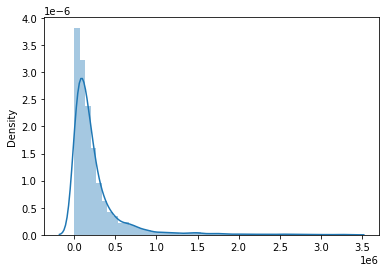

In [ ]:
import seaborn as sns
plot = sns.distplot(list(sales_ranks.values())) 

We can see that the sales rankings is heavily skewed right as expected, so keeping the low ranked products may skew the results heavily. I will be doing rank <= 5000 as I think it captures most of the top product data.

In [ ]:
best_asins = [asin for asin, rank in sales_ranks.items() if rank <= 5000]

In [ ]:
best_asins[:3]

['B0001LGWEQ', 'B000E8F2TM', 'B000G42Z2Q']

In [ ]:
len(best_asins)

373

This takes us down to 373 product ASINs and then I'll filter the reviews that have these ASINs.

In [ ]:
top_reviews = {}

with gzip.open("/content/reviews_Clothing_Shoes_and_Jewelry.json.gz") as reviews:
    for i, review in enumerate(reviews):
        review = json.loads(review)
        _id = "%s.%s" % (review["asin"], review["reviewerID"])
        if review["asin"] in best_asins:
          top_reviews[_id] = review

In [ ]:
len(top_reviews)

4680

This takes us down to 4680 reviews. 

In [ ]:
with open("/content/MSDS_Final_TopReviews.jsonl", "w") as top_reviews_file:
    for k, v in top_reviews.items():
        review = json.dumps(v)
        top_reviews_file.write(f"{review}\n")

In [ ]:
texts = []
with open("/content/MSDS_Final_TopReviews.jsonl") as top_reviews_file:
    for review in top_reviews_file:
        data = json.loads(review)
        texts.append(data["reviewText"])

In [ ]:
texts[0]

"I've had this watch for over a year now and wear it daily. I love it and the features it provides."

In [ ]:
len(texts)

4680

#Model

Now for the modeling in BERTopic. I use sklearn's countvectorizer to integrate stopwowrds into BERTopic. This way I don't get unmeaningful words like 'the'.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
vectorizer_model = CountVectorizer(stop_words="english")

In [ ]:
from bertopic.representation import MaximalMarginalRelevance

In [ ]:
topic_model = BERTopic(language="english", vectorizer_model=vectorizer_model, calculate_probabilities=True, verbose=True, representation_model = MaximalMarginalRelevance(diversity=0.2))
topics, probs = topic_model.fit_transform(texts)

Batches:   0%|          | 0/147 [00:00<?, ?it/s]

2023-03-07 05:59:08,629 - BERTopic - Transformed documents to Embeddings
2023-03-07 05:59:22,618 - BERTopic - Reduced dimensionality
2023-03-07 05:59:23,917 - BERTopic - Clustered reduced embeddings


In [ ]:
freq = topic_model.get_topic_info() 
freq.head(5)

,Topic,Count,Name
0,-1,1480,-1_shoes_shoe_size_fit
1,0,479,0_running_shoes_run_shoe
2,1,200,1_socks_sock_feet_basketball
3,2,182,2_nike_nikes_quality_boots
4,3,158,3_comfortable_fit_loves_bought


In [ ]:
topic_model.get_topic(0)

[('running', 0.039229281496122544),
 ('shoes', 0.019566015099607113),
 ('run', 0.019144109611429188),
 ('shoe', 0.014844440467813682),
 ('gym', 0.010670138348253725),
 ('miles', 0.01066375856084838),
 ('nike', 0.010099909992763704),
 ('runner', 0.009941562637737784),
 ('runs', 0.009650929762341188),
 ('fit', 0.009179915694985444)]

In [ ]:
topic_model.visualize_topics()

In [ ]:
topic_model.visualize_hierarchy(top_n_topics=50)

In [ ]:
topic_model.visualize_barchart(top_n_topics=5)

In [ ]:
topic_model.visualize_heatmap(n_clusters=20, width=1000, height=1000)

In [ ]:
topic_model_reduc = topic_model

#User Reduced Model

In [ ]:
topic_model_reduc.reduce_topics(texts, nr_topics=12)

2023-03-07 05:59:50,092 - BERTopic - Reduced number of topics from 62 to 12


In [ ]:
topic_model_reduc.visualize_topics()

In [ ]:
topic_model_reduc.visualize_barchart(top_n_topics=11, n_words=8)

In [ ]:
topic_model_reduc.visualize_heatmap(n_clusters=10, width=1000, height=1000)

In [ ]:
topic_model_reduc.visualize_hierarchy(top_n_topics=11)

In [ ]:
topic_model_reduc.get_document_info(texts)

,Document,Topic,Name,Top_n_words,Probability,Representative_document
0,I've had this watch for over a year now and we...,0,0_shoes_shoe_comfortable_fit,shoes - shoe - comfortable - fit - size - nike...,0.142493,False
1,I have been using the triax C5 for about a yea...,0,0_shoes_shoe_comfortable_fit,shoes - shoe - comfortable - fit - size - nike...,0.068211,False
2,my husband loves the big face on the watch tha...,0,0_shoes_shoe_comfortable_fit,shoes - shoe - comfortable - fit - size - nike...,0.200350,False
3,I purchased this watch and was very happy with...,0,0_shoes_shoe_comfortable_fit,shoes - shoe - comfortable - fit - size - nike...,1.000000,False
4,Watch is exactly what I hoped for. Seller was ...,0,0_shoes_shoe_comfortable_fit,shoes - shoe - comfortable - fit - size - nike...,1.000000,False
...,...,...,...,...,...,...
4675,Excellent shoe! It's just what I was looking f...,-1,-1_shoes_shoe_size_comfortable,shoes - shoe - size - comfortable - fit - nike...,0.714973,False
4676,JORDAN RETRO 11 s.... THIS SHOE SPEAKS FOR ITS...,-1,-1_shoes_shoe_size_comfortable,shoes - shoe - size - comfortable - fit - nike...,0.719778,False
4677,Cool sneaker worth it,0,0_shoes_shoe_comfortable_fit,shoes - shoe - comfortable - fit - size - nike...,1.000000,False
4678,Very nice!!!!,0,0_shoes_shoe_comfortable_fit,shoes - shoe - comfortable - fit - size - nike...,0.439900,False


#Auto Reduced Model

In [ ]:
topic_model_auto = BERTopic(language="english", vectorizer_model=vectorizer_model, calculate_probabilities=True, verbose=True, representation_model = MaximalMarginalRelevance(diversity=0.2), nr_topics="auto")

In [ ]:
topics_auto, probs_auto = topic_model_auto.fit_transform(texts)

Batches:   0%|          | 0/147 [00:00<?, ?it/s]

2023-03-07 05:32:48,124 - BERTopic - Transformed documents to Embeddings
2023-03-07 05:33:05,091 - BERTopic - Reduced dimensionality
2023-03-07 05:33:06,216 - BERTopic - Clustered reduced embeddings
2023-03-07 05:33:32,573 - BERTopic - Reduced number of topics from 62 to 23


In [ ]:
topic_model_auto.visualize_topics()

In [ ]:
topic_model_auto.visualize_barchart(top_n_topics=23, n_words=8)

Here's the saved png that loads better on github:

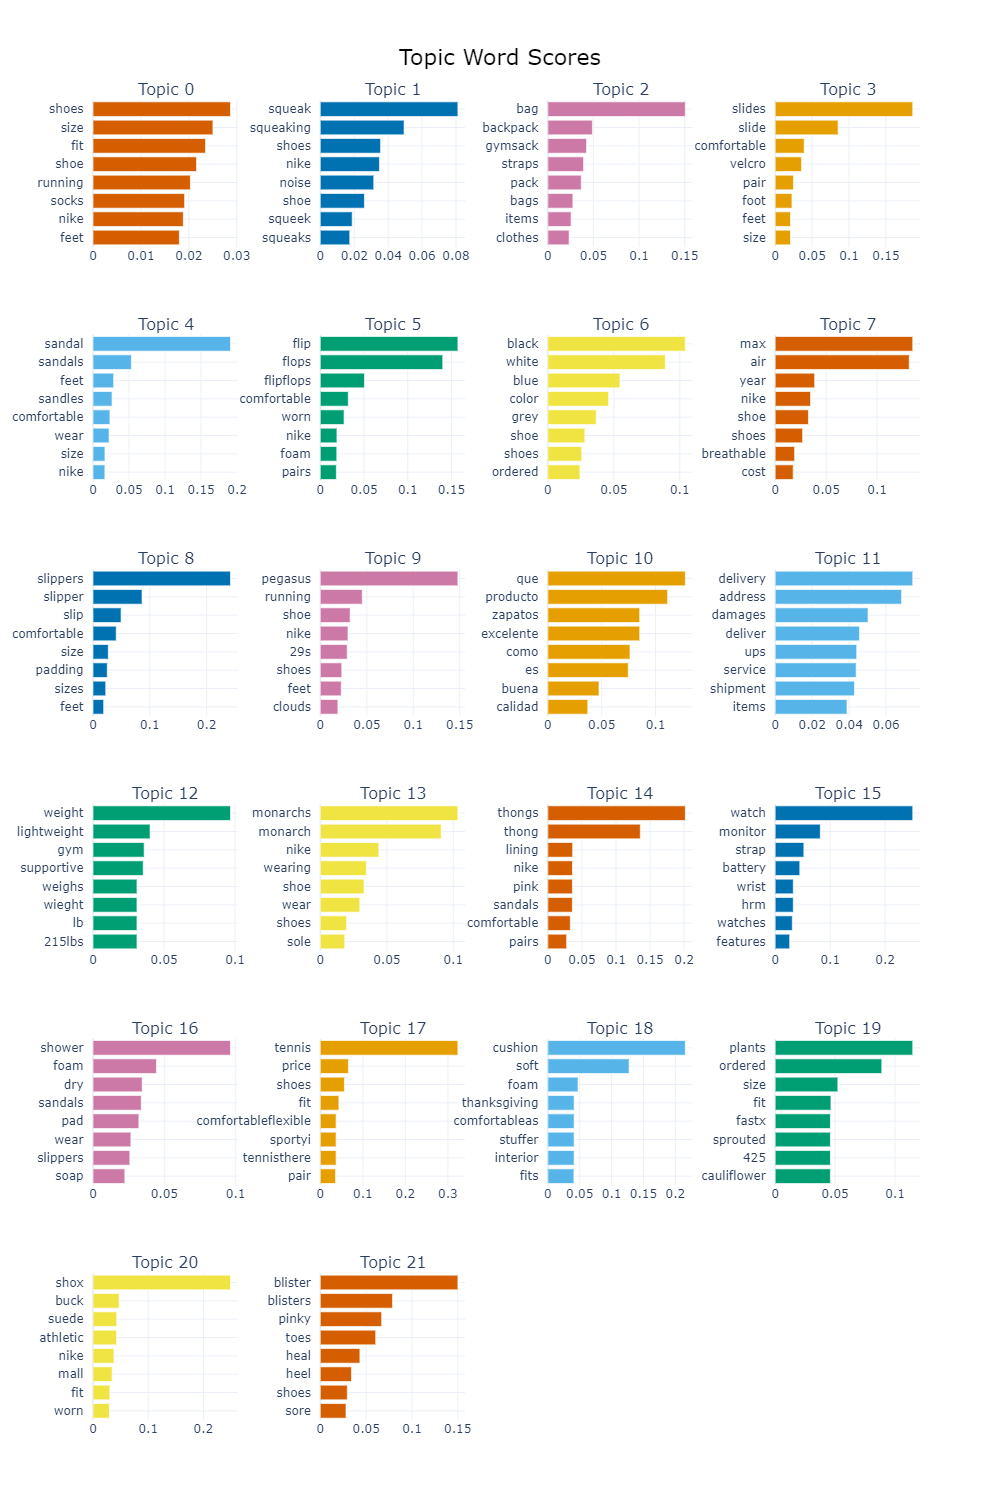

##Actionable Insights

**Topic 15: Watches**

Looking at this topic, it likely represents the nike watch products. We can see that monitor, features, strap, and battery are important words here. I would suggest their marketing department to focus on these features in their advertisments and see if any of these features are contributing negatively to user reviews.

**Topic 7: Air Max**

Some important words in this topic are breathable and cost. It could mean that something customers really value about the shoe is the breathability which could be something the marketing department could try to emphasize. Customers could also be complaining about cost so maybe marketing a low priced variant of Air Max could capture that specific market.

**Topic 11: Delivery**

This topic likely represent delivery related reviews. As Damages is a very high ranking word here along with UPS, Nike may consider checking their UPS related delivery issues and consider changing shipping companies as damages can heavily negatively impact customer satisfaction.

**Topic 1: Squeakiness**

This topic shows that one of the major complaints about Nike shoes are squeakiness. I would suggest Nike to find ways to reduce the noise in their shoes or market a new product that effectively captures the market of people who do not enjoy shoe noise like a silent shoe.

**Topic 21: Blisters**

It appears that there are a subet of reviews that complain about Nike shoes giving them blisters. It appears the pink toes and the heels are particular places of soreness and maybe the engineering and design department can look in to those issues as comfortability seems to be a very important word across many topics.